In [1]:
import os
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import spotipy
import sqlite3
from sklearn.cluster import KMeans
from sqlite3 import Error
import seaborn as sns
import matplotlib.pyplot as plt
from spotipy.oauth2 import SpotifyClientCredentials
import time
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from openTSNE import TSNE as openTSNE
from wordcloud import WordCloud
from wordcloud import STOPWORDS as STOPWORDS

In [2]:
def connect_db(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)
    return conn

In [3]:
# connect to database
conn = connect_db('data.db')
cur = conn.cursor()

In [4]:
# Getting the target data
# Extract playlists that have the input words in their titles to use as training data
input_words = ['summer', 'beach', 'throwbacks']
# sql_select = '''SELECT AVG(danceability), AVG(energy), AVG(key), AVG(loudness), 
# AVG(mode), AVG(speechiness), AVG(acousticness), AVG(instrumentalness), AVG(liveness), 
# AVG(valence), AVG(tempo), AVG(duration_ms), AVG(time_signature) FROM avg_features_by_playlist WHERE'''

sql_select = '''SELECT * FROM avg_features_by_playlist WHERE'''
for w in range(len(input_words)):
    sql_select += " name LIKE '%" + input_words[w] + "%'"
    if w != len(input_words) -1:
        sql_select += " OR" 
pl_train = cur.execute(sql_select).fetchall()

In [5]:
# Get X data (average playlist features)
data_cols = ['pid', 'name', 'danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature']
feature_cols = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature']
test_cols = ['pid', 'name', 'danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature']

data_rows = cur.execute('select * from avg_features_by_playlist where pid > (select MIN(pid) from avg_features_by_playlist) order by pid').fetchall()


# test_pl = cur.execute('''select tracks_in_playlist.pid, tracks_in_playlist.track_uri, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, duration_ms, time_signature 
# from features_by_track left join tracks_in_playlist on
# features_by_track.track_uri = tracks_in_playlist.track_uri 
# where pid = (select MIN(pid) from avg_features_by_playlist)''').fetchall()


test_data = pd.DataFrame(pl_train, columns=test_cols)
data = pd.DataFrame(data_rows, columns=data_cols)

print(test_data.head())
print(data.head(5))

   pid             name  danceability    energy  key   loudness  mode  \
0    0       Throwbacks      0.664077  0.781077  0.0  -4.891212   0.0   
1  115            beach      0.658866  0.728402  0.0  -6.430356   0.0   
2  125           summer      0.677868  0.703642  0.0  -5.698415   0.0   
3  169     Summer Chill      0.646425  0.506537  0.0 -10.315649   0.0   
4  181  Summer Playlist      0.591926  0.603926  0.0  -6.992222   0.0   

   speechiness  acousticness  instrumentalness  liveness   valence  \
0     0.103698      0.083674          0.000674  0.187087  0.642750   
1     0.093119      0.166368          0.005590  0.197189  0.673794   
2     0.202636      0.139387          0.000211  0.226962  0.632208   
3     0.112705      0.350255          0.209132  0.147148  0.487011   
4     0.084893      0.161321          0.002425  0.162344  0.336756   

        tempo    duration_ms  time_signature  
0  121.157500  221777.461538        4.000000  
1  118.341402  223320.860825        3.979381  

In [6]:
conn.close()

In [7]:
# Scale the data


y = test_data[feature_cols].mean()

scaler = StandardScaler(with_mean=True, with_std=True).fit(data[feature_cols].values)

scaled_x = scaler.transform(data[feature_cols].values)
scaled_y = scaler.transform(np.array(y).reshape(1,-1))
scaled_features = pd.DataFrame(scaled_x)
tsne = openTSNE(perplexity=30, metric='euclidean', n_jobs=-1, random_state=0, verbose=False)
tsne_transformer = tsne.fit(scaled_x)
data_df = pd.DataFrame(tsne_transformer.transform(scaled_x), columns =['X', 'Y'])

print(data_df)

              X          Y
0     21.563168  21.268811
1    -25.466710  -7.460980
2     27.113151  17.910658
3      3.765092   0.340076
4    -37.833910  15.311551
...         ...        ...
9994 -17.453539 -45.190207
9995 -58.838690 -27.454794
9996  12.108994 -12.820617
9997  -6.243289 -30.163967
9998  12.062308  38.578371

[9999 rows x 2 columns]


<AxesSubplot:xlabel='X', ylabel='Y'>

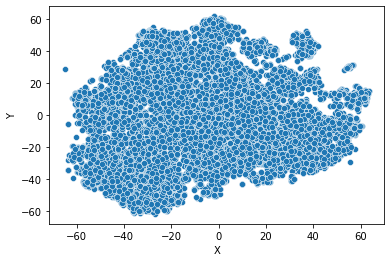

In [8]:
sns.scatterplot(x='X', y='Y', data=data_df, legend=None)

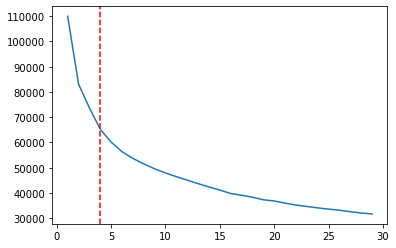

In [9]:
#TODO:
# needs to be tested and K updated below
#calculate how many K clusters there should be 
wcss = [] 
for number_of_clusters in range(1, 30): 
    kmeans = KMeans(n_clusters = number_of_clusters, random_state = 42)
    kmeans.fit(scaled_x) 
    wcss.append(kmeans.inertia_)
wcss

ks = range(1, 30)
plt.plot(ks, wcss)
plt.axvline(4, linestyle='--', color='r')

In [10]:
# initialize KMeans
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit(scaled_x)
labels = clusters.labels_
data_df['cluster'] = pd.Categorical(labels)

target_cluster = kmeans.predict(scaled_y)
print(target_cluster[0])

10


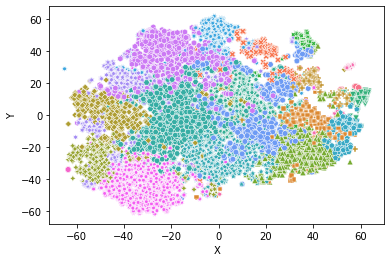

In [11]:
sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data=data_df, legend=None)
plt.show()

Cluster number  0


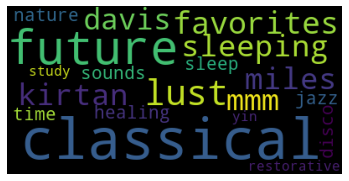

Cluster number  1


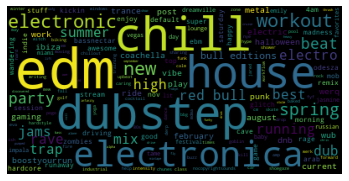

Cluster number  2


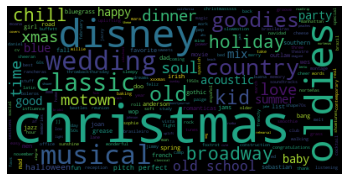

Cluster number  3


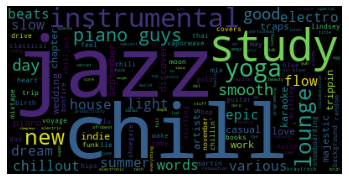

Cluster number  4


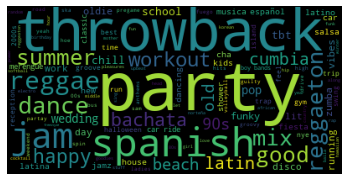

Cluster number  5


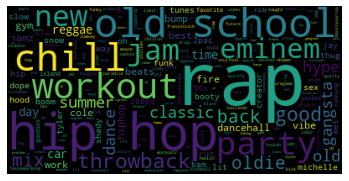

Cluster number  6


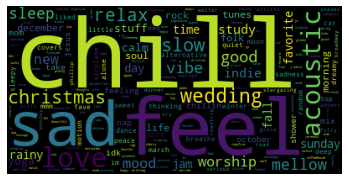

Cluster number  7


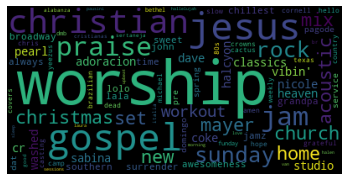

Cluster number  8


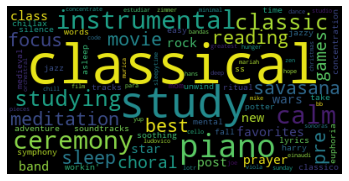

Cluster number  9


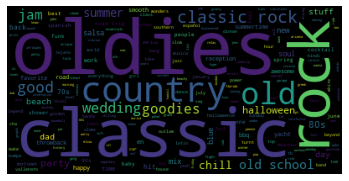

Cluster number  10


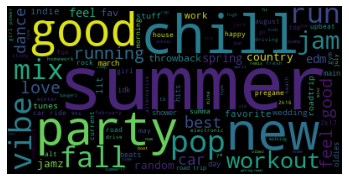

Cluster number  11


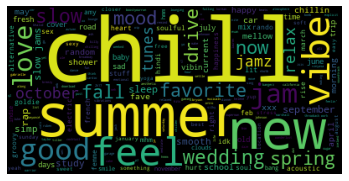

Cluster number  12


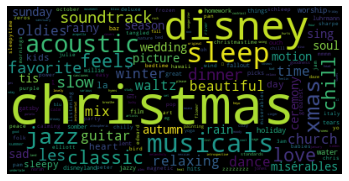

Cluster number  13


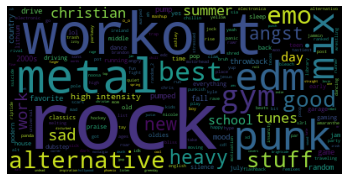

Cluster number  14


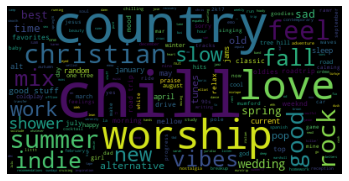

Cluster number  15


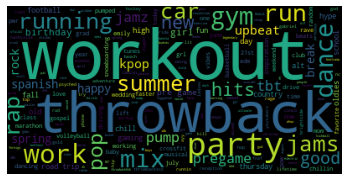

Cluster number  16


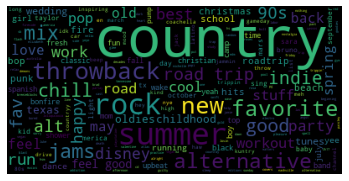

Cluster number  17


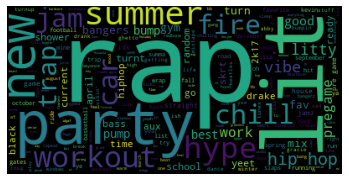

Cluster number  18


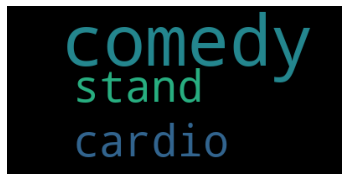

Cluster number  19


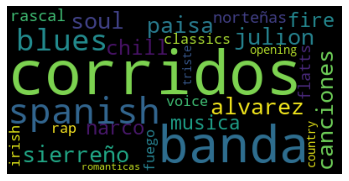

In [15]:
data_df["playlist_name"] = data['name'].str.lower()
# display(data_df)

# we want to perform a pivot on data_df so that each cluster number is a column with row value equal to the playlist name.
# from there we can sum up that column to get the whole lsit of strings of playlist names for each cluster (column)
original_df = data_df.pivot(columns='cluster')['playlist_name'].reset_index()
original_df.columns.name = None
original_df = original_df.fillna('')
# original_df.head(20)
# print(original_df.columns)

#list of words to ignore
stop_words = STOPWORDS.update(["i", "it", "me", "my", "that", "the", "of", "than", "then", 
"when", "if", "a", "there", "playlist", "music", "song", "songs", "to", "too", "get", "as", "this", 
"am", "is", "are", "has", "and", "aa", "aaa", 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 
'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'])

wordclouds = {}
for i in range(n_clusters):
    original_df.replace(np.nan, '')
    original_df[i] = original_df[i].astype(str) #.sum(skipna=True))
    wordclouds["wordcloud" + str(i)] = WordCloud(stopwords=stop_words).generate(' '.join(original_df[i]))

index = 0
for val in wordclouds.values():
    print("Cluster number ", index)
    plt.imshow(val)
    plt.axis("off")
    plt.show()
    index += 1

In [179]:
def get_target_cluster_songs(target_cluster):
    data_df["pid"] = data['pid']
    original_df = data_df.pivot(columns='cluster', values='pid')
    target_cluster_df = original_df[[target_cluster]].dropna()
    conn = connect_db('data.db')
    cur = conn.cursor()
    sql = '''SELECT features_by_track.* FROM features_by_track join tracks_in_playlist on features_by_track.track_uri = tracks_in_playlist.track_uri
        WHERE '''
    for pid in target_cluster_df[target_cluster].values:
        sql += "tracks_in_playlist.pid = " + str(int(pid))
        sql += " OR "
    sql = sql[:-3]
    cols = ["track_uri",
        "danceability",
        "energy",
        "key",
        "loudness",
        "mode",
        "speechiness",
        "acousticness",
        "instrumentalness",
        "liveness",
        "valence",
        "tempo",
        "duration_ms",
        "time_signature"]
        
    result = cur.execute(sql).fetchall()
    
    conn.close()
    tracks = pd.DataFrame(result, columns = cols)
    tracks = tracks[tracks['track_uri'].map(tracks['track_uri'].value_counts()) > 3]
    
    #tracks['counts'] = tracks.groupby(['track_uri'])['time_signature'].transform('count')
    
    #tracks = tracks.drop_duplicates(subset=['track_uri'])
    #song_instances = tracks['counts'].sum()

    
    num_unique_songs = len(pd.unique(tracks['track_uri']))
    print(len(tracks), " song instances fetched")
    print(num_unique_songs, " unique songs fetched")
    print(tracks.head(5))
    return tracks
    

In [180]:
target_cluster_songs = get_target_cluster_songs(target_cluster[0])

62261  song instances fetched
4863  unique songs fetched
                 track_uri  danceability  energy  key  loudness  mode  \
61  5SE57ljOIUJ1ybL9U6CuBH         0.598   0.775  1.0    -4.035   0.0   
64  06u5LrUpbosQlQ1QJFhPpG         0.577   0.523  0.0    -5.538   0.0   
66  60kqoWSXSbiDJaDxgi8GG1         0.550   0.661  1.0    -7.363   1.0   
68  6jG2YzhxptolDzLHTGLt7S         0.583   0.621  5.0    -6.902   0.0   
72  1mXVgsBdtIVeCLJnSnmtdV         0.681   0.372  5.0    -8.237   1.0   

    speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
61       0.0545       0.02200          0.000000    0.0677    0.687  129.819   
64       0.0429       0.49100          0.000000    0.1470    0.290  134.930   
66       0.0611       0.01780          0.000036    0.1500    0.142  162.034   
68       0.0479       0.00972          0.001060    0.1810    0.399  140.036   
72       0.0432       0.64000          0.000000    0.1690    0.476   91.873   

    duration_ms  time_signatu

In [189]:
#feature_cols.append('counts')
#feature_cols.remove('counts')
scaler_song = StandardScaler(with_mean=True, with_std=True).fit(target_cluster_songs[feature_cols].values)

scaled_song_x = scaler_song.transform(target_cluster_songs[feature_cols].values)
scaled_song_features = pd.DataFrame(scaled_song_x)
tsne_song = openTSNE(perplexity=30, metric='euclidean', n_jobs=-1, random_state=0, verbose=False)
tsne_transformer_song = tsne_song.fit(scaled_song_x)
song_data_df = pd.DataFrame(tsne_transformer_song.transform(scaled_song_x), columns =['X', 'Y'])

print(song_data_df)

               X          Y
0     -65.253040 -40.540988
1       5.530855 -29.983745
2      30.245984  51.383894
3       2.979579 -16.431339
4      69.145476  -1.430732
...          ...        ...
62256  72.968111 -87.445848
62257  16.285847 -29.119860
62258 -30.974152  89.188366
62259  -8.884897 -31.163946
62260  80.837116  59.148581

[62261 rows x 2 columns]


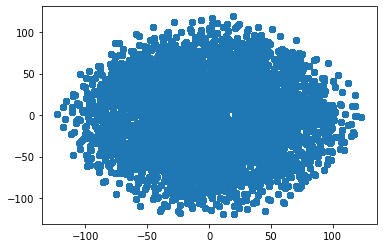

In [190]:
plt.scatter(x='X', y='Y', data=song_data_df)

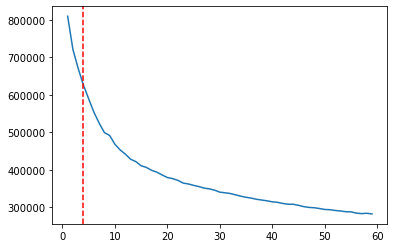

In [191]:
wcss = [] 
for number_of_clusters in range(1, 60): 
    kmeans = KMeans(n_clusters = number_of_clusters, random_state = 42)
    kmeans.fit(scaled_song_x) 
    wcss.append(kmeans.inertia_)
wcss

ks = range(1, 60)
plt.plot(ks, wcss)
plt.axvline(4, linestyle='--', color='r')

In [192]:
n_clusters = 20
kmeans_song = KMeans(n_clusters=n_clusters, random_state=42)
clusters_song = kmeans_song.fit(scaled_song_x)
labels_song = clusters_song.labels_
song_data_df['cluster'] = pd.Categorical(labels_song)

target_cluster_song = kmeans_song.predict(scaled_y)
print(target_cluster_song[0])

12


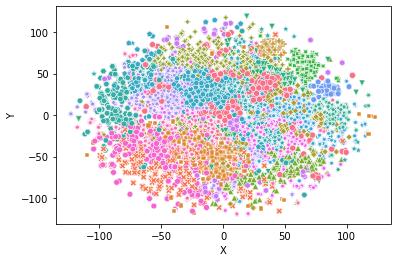

In [193]:
sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data=song_data_df, legend=None)
plt.show()

In [196]:
def get_song_target_cluster_songs(target_cluster):
    song_data_df["track_uri"] = target_cluster_songs['track_uri']
    original_df = song_data_df.pivot(columns='cluster', values='track_uri')
    target_cluster_df = original_df[[target_cluster]].dropna()
    
    conn = connect_db('data.db')
    cur = conn.cursor()
    sql = "SELECT track_name, track_uri FROM tracks WHERE "
    for uri in target_cluster_df[target_cluster].values:
        sql += "track_uri = " + "\"" + uri + "\""
        sql += " OR "
    sql = sql[:-3]
    cols = ["track_name", "track_uri"]
    
    result = cur.execute(sql).fetchall()
    conn.close()

    tracks = pd.DataFrame(result, columns = cols)

    #unique_songs = pd.unique(tracks['track_uri'])
    tracks = tracks.drop_duplicates(subset=['track_uri'])
    print(len(tracks), " songs fetched")
    print(tracks)
    return tracks

In [197]:
result_songs = get_song_target_cluster_songs(target_cluster_song[0])

2048  songs fetched
                                track_name               track_uri
0                                Attention  4iLqG9SeJSnt0cSPICSjxv
1                             Now Or Never  7i2DJ88J7jQ8K7zqFX2fW8
2         Surprise Party (feat. Blackbear)  5UiT4e4DHwZrcVIXojU5um
3                       Down In The Valley  5aVhFEvhPKibeOoCx7aNtG
4                           Lost And Found  3R2bkLqP197fl3vKHpONrg
...                                    ...                     ...
2043                              For Free  5TqBAOIBe0bQA0spNdcG3k
2044                      Forgot About Dre  0Zh5U48tZNeAzzLTV1CVBE
2045                        All Falls Down  4FHu9bOzBjZurx89CMa42L
2046            So High (feat. Ghost Loft)  0odHj0qIf86vHBsXB30IkZ
2047  Love On The Brain - Don Diablo Remix  2SqXhFOHbUJ8Opj0poEDGV

[2048 rows x 2 columns]
